[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✅ Columns detected: text → 'english_comment', label → 'sentiment'
Original shape: (8512, 4)

🔹 Sample Cleaned Text:
mr rashidpour baby boy week num moment born bec...
cool thief beaming_face_with_smiling_eyes beami...
hello possible n't use word ct scan program n't...
                         save internet phone money
mr rashidpour gave frozen meat village shura vi...

=== Basic EDA ===
After cleaning shape: (8508, 3)
Missing values:
 english_comment    0
sentiment          0
clean_text         0
dtype: int64
Duplicates: 264


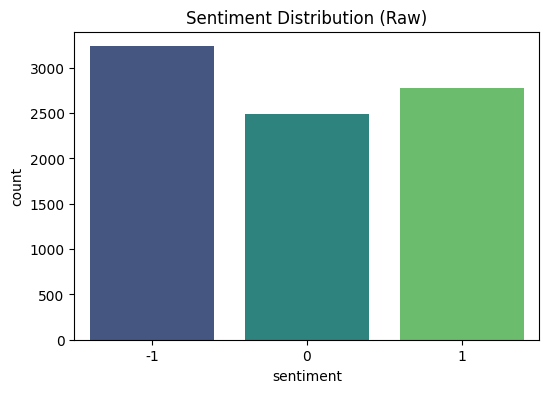


--- Text Length Summary ---
          char_len     word_len
count  8508.000000  8508.000000
mean    102.182181    18.785261
std     168.517779    29.787146
min       1.000000     1.000000
25%      25.000000     5.000000
50%      54.000000    10.000000
75%     115.000000    22.000000
max    2625.000000   469.000000


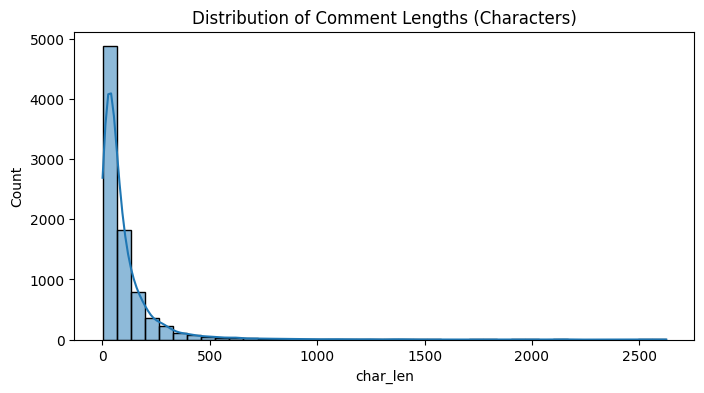

Classes: [np.int64(-1), np.int64(0), np.int64(1)]


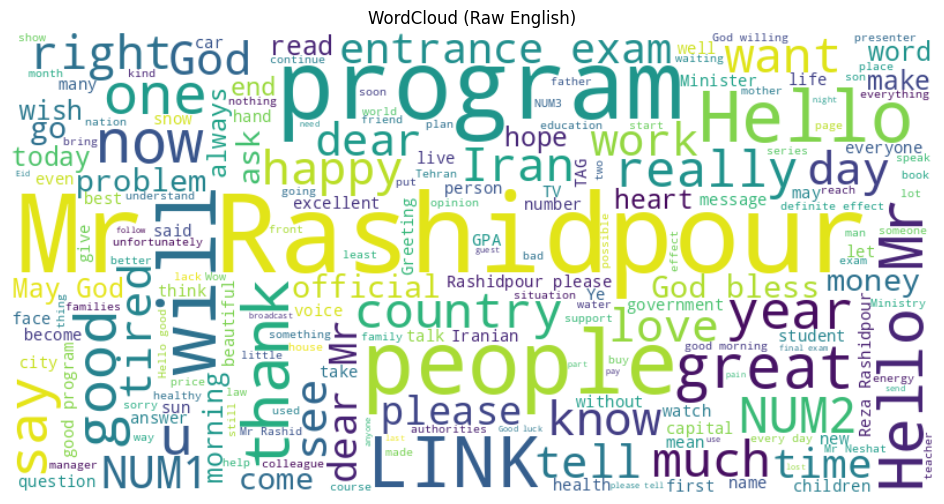

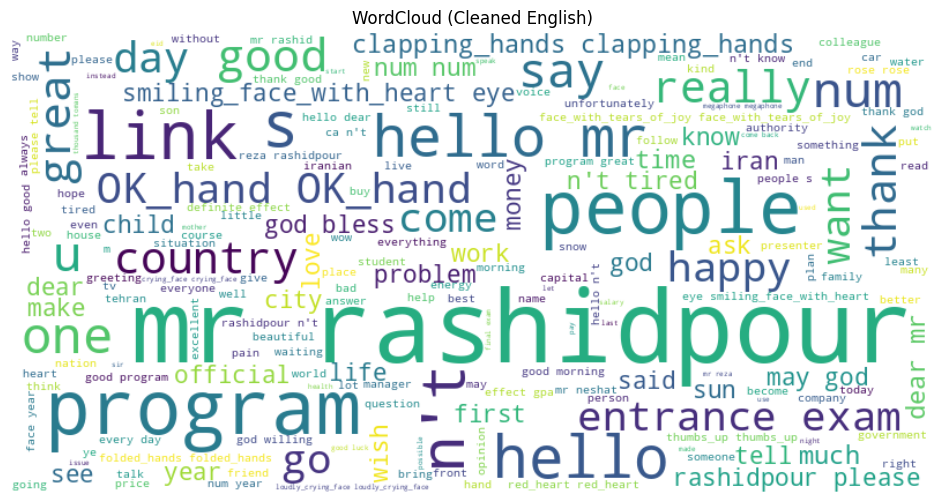


Data split → Train: 5665, Val: 1214, Test: 1214
TF-IDF shapes → Train: (5665, 4055), Val: (1214, 4055), Test: (1214, 4055)


In [3]:
# ==========================================================
# 🧠 English Text Preprocessing (Fixed to Preserve 8K+ Rows)
# ==========================================================
import os
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import demoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

# ==========================================================
# 📦 Downloads
# ==========================================================
import nltk
nltk.download('punkt_tab')
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
demoji.download_codes()

# ==========================================================
# ⚙️ Setup & Constants
# ==========================================================
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

DATA_PATH = r"english_comments.csv"   # <--- update path if needed
OUTPUT_DIR = r"models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ==========================================================
# 📥 Load Dataset
# ==========================================================
df = pd.read_csv(DATA_PATH)
TEXT_COL = next((c for c in ["english_comment", "comment", "text", "message", "review"] if c in df.columns), None)
LABEL_COL = next((c for c in ["sentiment", "label", "target", "category"] if c in df.columns), None)

if TEXT_COL is None or LABEL_COL is None:
    raise ValueError("Couldn't find text/label columns in dataset!")

print(f"✅ Columns detected: text → '{TEXT_COL}', label → '{LABEL_COL}'")
print("Original shape:", df.shape)

# ==========================================================
# 🧹 Text Cleaning Functions
# ==========================================================
lemmatizer = WordNetLemmatizer()
STOPWORDS = set(stopwords.words("english"))

RE_URL = re.compile(r"http\S+|www\.\S+")
RE_HTML = re.compile(r"<.*?>")
RE_NONALPHA = re.compile(r"[^a-zA-Z\s:,_!?']")  # keep punctuation and emoji text

def handle_emojis(text):
    """Convert emojis to text but keep names (no deletion)."""
    return emoji.demojize(str(text), language="en")

def clean_repetitions(text):
    """Limit excessive letter repetition like 'soooo' → 'soo'."""
    return re.sub(r"(.)\1{2,}", r"\1\1", text)

def preprocess_english(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()

    # Convert emojis → text
    text = handle_emojis(text)

    # Remove URLs, HTML, mentions, hashtags, digits
    text = RE_URL.sub(" ", text)
    text = RE_HTML.sub(" ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#\w+", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = RE_NONALPHA.sub(" ", text)

    # Normalize spaces and repetitions
    text = clean_repetitions(text)
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize, remove stopwords, lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in STOPWORDS and len(t) > 1]

    return " ".join(tokens)

# ==========================================================
# 🧽 Apply Preprocessing
# ==========================================================
df = df[[TEXT_COL, LABEL_COL]].copy()
df.dropna(subset=[TEXT_COL, LABEL_COL], inplace=True)
df["clean_text"] = df[TEXT_COL].apply(preprocess_english)

print("\n🔹 Sample Cleaned Text:")
print(df["clean_text"].head(5).to_string(index=False))

# ==========================================================
# 📊 EDA
# ==========================================================
print("\n=== Basic EDA ===")
print("After cleaning shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated(subset=[TEXT_COL]).sum())

plt.figure(figsize=(6,4))
sns.countplot(x=df[LABEL_COL], palette="viridis")
plt.title("Sentiment Distribution (Raw)")
plt.show()

# Length statistics
df["char_len"] = df[TEXT_COL].astype(str).str.len()
df["word_len"] = df[TEXT_COL].astype(str).str.split().apply(len)

print("\n--- Text Length Summary ---")
print(df[["char_len","word_len"]].describe())

plt.figure(figsize=(8,4))
sns.histplot(df["char_len"], bins=40, kde=True)
plt.title("Distribution of Comment Lengths (Characters)")
plt.show()

# ==========================================================
# 🧼 Deduplication (keep all short valid texts)
# ==========================================================
df = df.drop_duplicates(subset=[TEXT_COL])
df = df[df["clean_text"].str.len() > 1]  # keep short words like "ok", "hi"

# ==========================================================
# 🔖 Label Encoding
# ==========================================================
le = LabelEncoder()
df["label_enc"] = le.fit_transform(df[LABEL_COL])
print("Classes:", list(le.classes_))

# ==========================================================
# ☁️ WordClouds
# ==========================================================
wc_raw = WordCloud(width=800, height=400, background_color="white", max_words=200).generate(" ".join(df[TEXT_COL].astype(str)))
plt.figure(figsize=(12,6))
plt.imshow(wc_raw, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud (Raw English)")
plt.show()

wc_clean = WordCloud(width=800, height=400, background_color="white", max_words=200).generate(" ".join(df["clean_text"]))
plt.figure(figsize=(12,6))
plt.imshow(wc_clean, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud (Cleaned English)")
plt.show()

# ==========================================================
# ✂️ Train / Validation / Test Split
# ==========================================================
X_text = df["clean_text"]
y = df["label_enc"]

X_text, y = shuffle(X_text, y, random_state=SEED)

X_train_text, X_temp_text, y_train, y_temp = train_test_split(
    X_text, y, test_size=0.3, random_state=SEED, stratify=y
)
X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp_text, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print(f"\nData split → Train: {len(X_train_text)}, Val: {len(X_val_text)}, Test: {len(X_test_text)}")

# ==========================================================
# 🔠 TF-IDF Vectorizer
# ==========================================================
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=20000,        # captures rich vocabulary without overfitting
    ngram_range=(1, 2),        # unigrams + bigrams capture short context
    sublinear_tf=True,         # reduces the weight of overly frequent words
    min_df=3,                  # ignore words appearing in <3 documents
    max_df=0.85,               # ignore words appearing in >85% of documents
    stop_words='english'       # remove common stopwords automatically
)

X_train = vectorizer.fit_transform(X_train_text)
X_val   = vectorizer.transform(X_val_text)
X_test  = vectorizer.transform(X_test_text)

print(f"TF-IDF shapes → Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

In [2]:
!pip install emoji
!pip install demoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.9 MB/s eta 0:00:00



=== Logistic Regression Performance ===
Training Accuracy:   0.6927
Validation Accuracy: 0.6680
Test Accuracy:       0.6483
Test F1-score:       0.6342

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.58      0.86      0.69       479
           1       0.70      0.37      0.48       332
           2       0.76      0.63      0.69       403

    accuracy                           0.65      1214
   macro avg       0.68      0.62      0.62      1214
weighted avg       0.67      0.65      0.63      1214



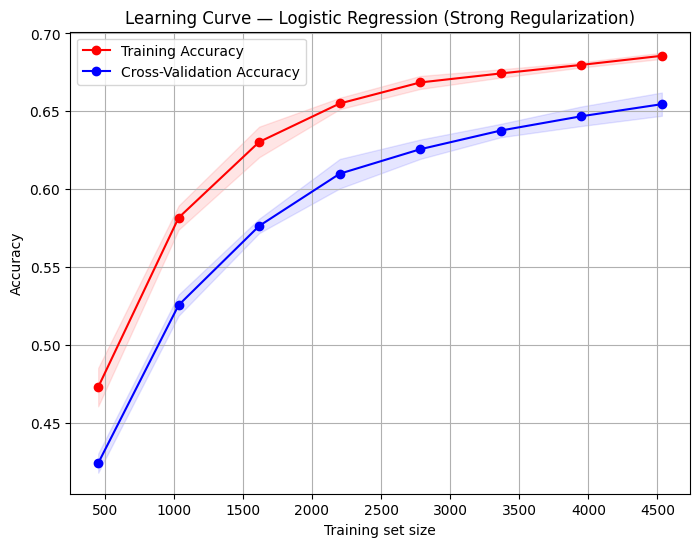

In [4]:
# ==========================================================
# 3️⃣ Logistic Regression (High Regularization)
# ==========================================================
from sklearn.ensemble import IsolationForest, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report
lr = LogisticRegression(
    penalty='l2',
    C=0.04,                  # ✅ strong regularization
    solver='liblinear',
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)

lr.fit(X_train, y_train)

# ==========================================================
# 4️⃣ Evaluate Performance
# ==========================================================
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)
y_test_pred = lr.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n=== Logistic Regression Performance ===")
print(f"Training Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")
print(f"Test F1-score:       {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

# ==========================================================
# 5️⃣ Learning Curve — Verify No Overfitting
# ==========================================================
train_sizes, train_scores, val_scores = learning_curve(
    lr, X_train, y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color="red", label="Training Accuracy")
plt.plot(train_sizes, val_mean, 'o-', color="blue", label="Cross-Validation Accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color="red")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1, color="blue")
plt.title("Learning Curve — Logistic Regression (Strong Regularization)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()



=== Random Forest Performance ===
Training Accuracy:   0.6498
Validation Accuracy: 0.6161
Test Accuracy:       0.6
Test F1-score:       0.5965

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.73      0.49      0.59       479
           1       0.44      0.72      0.55       332
           2       0.70      0.60      0.65       403

    accuracy                           0.59      1214
   macro avg       0.62      0.61      0.59      1214
weighted avg       0.64      0.59      0.60      1214



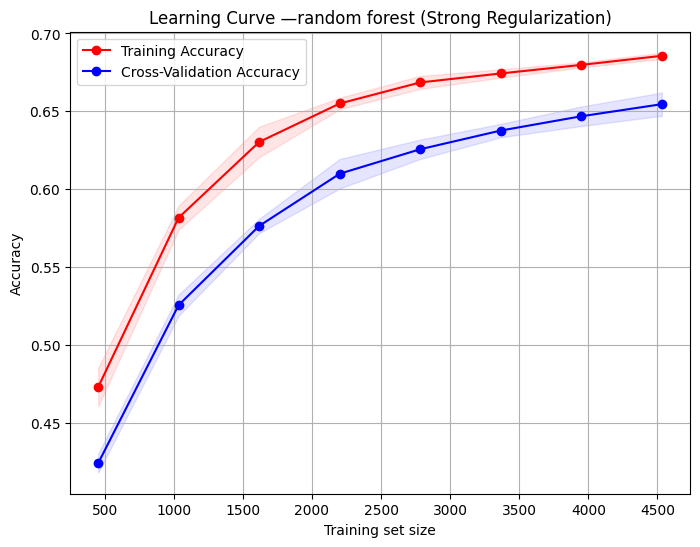

In [5]:
rf = RandomForestClassifier( n_estimators=1000, # More trees → stable performance
                            max_depth=18, # Limit depth to avoid memorization
                            min_samples_split=10, # Require more samples per split
                            min_samples_leaf=6, # Each leaf must have enough samples
                            max_features='sqrt', # Less correlation between trees
                            bootstrap=True, # Adds randomness → regularization
                            class_weight='balanced_subsample', # Handle class imbalance
                            oob_score=True, # Out-of-bag accuracy → internal validation
                            random_state=42,
                            n_jobs=-1 )
rf.fit(X_train, y_train)

# ==========================================================
# 4️⃣ Evaluate Performance
# ==========================================================
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n=== Random Forest Performance ===")
print(f"Training Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.1f}")
print(f"Test F1-score:       {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))


plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color="red", label="Training Accuracy")
plt.plot(train_sizes, val_mean, 'o-', color="blue", label="Cross-Validation Accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color="red")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1, color="blue")
plt.title("Learning Curve —random forest (Strong Regularization)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()



=== XGBoost Performance ===
Training Accuracy:   0.6367
Validation Accuracy: 0.6170
Test Accuracy:       0.6079
Test F1-score:       0.5947

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.55      0.82      0.66       479
           1       0.60      0.34      0.44       332
           2       0.75      0.57      0.65       403

    accuracy                           0.61      1214
   macro avg       0.63      0.58      0.58      1214
weighted avg       0.63      0.61      0.59      1214



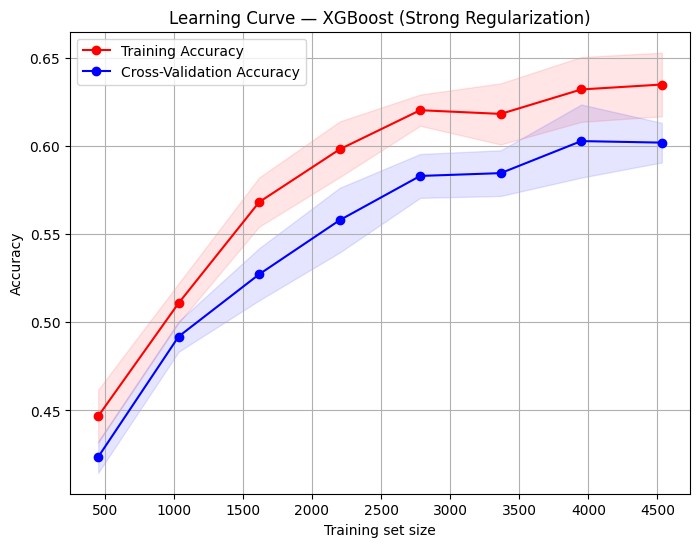

In [6]:
xg = XGBClassifier(
    n_estimators=600,             # moderate number of trees
    learning_rate=0.02,           # very small steps → smoother learning
    max_depth=3,                  # shallow trees = less variance
    subsample=0.6,                # use part of training data per tree
    colsample_bytree=0.5,         # use part of features per tree
    min_child_weight=10,          # demand larger samples per leaf
    gamma=0.6,                    # only strong splits
    reg_alpha=2,                  # strong L1 penalty
    reg_lambda=4,                 # strong L2 penalty
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1
)

xg.fit(X_train, y_train)

# ==========================================================
# 4️⃣ Evaluate Performance
# ==========================================================
y_train_pred = xg.predict(X_train)
y_val_pred = xg.predict(X_val)
y_test_pred = xg.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n=== XGBoost Performance ===")
print(f"Training Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")
print(f"Test F1-score:       {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

# ==========================================================
# 5️⃣ Learning Curve — Verify No Overfitting
# ==========================================================
train_sizes, train_scores, val_scores = learning_curve(
    xg, X_train, y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color="red", label="Training Accuracy")
plt.plot(train_sizes, val_mean, 'o-', color="blue", label="Cross-Validation Accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color="red")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1, color="blue")
plt.title("Learning Curve — XGBoost (Strong Regularization)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()



=== Extratrees Performance ===
Training Accuracy:   0.6680
Validation Accuracy: 0.6318
Test Accuracy:       0.6236
Test F1-score:       0.6295

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.72      0.57      0.64       479
           1       0.47      0.72      0.57       332
           2       0.75      0.60      0.67       403

    accuracy                           0.62      1214
   macro avg       0.65      0.63      0.63      1214
weighted avg       0.66      0.62      0.63      1214



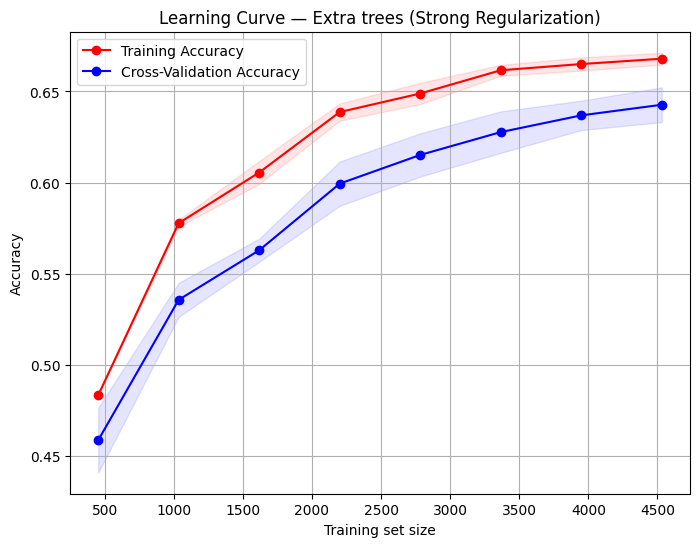

In [8]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(
    n_estimators=400,             # slightly more trees (stable average)
    max_depth=10,                 # shallow trees prevent memorizing
    min_samples_split=20,         # require more samples to split
    min_samples_leaf=10,          # avoid tiny leaves
    max_features='sqrt',          # fewer features per tree
    bootstrap=True,               # bootstrap adds randomness
    oob_score=True,               # out-of-bag validation
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
et.fit(X_train, y_train)

# ==========================================================
# 4️⃣ Evaluate Performance
# ==========================================================
y_train_pred = et.predict(X_train)
y_val_pred = et.predict(X_val)
y_test_pred = et.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n=== Extratrees Performance ===")
print(f"Training Accuracy:   {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")
print(f"Test F1-score:       {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

# ==========================================================
# 5️⃣ Learning Curve — Verify No Overfitting
# ==========================================================
train_sizes, train_scores, val_scores = learning_curve(
    et, X_train, y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color="red", label="Training Accuracy")
plt.plot(train_sizes, val_mean, 'o-', color="blue", label="Cross-Validation Accuracy")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color="red")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1, color="blue")
plt.title("Learning Curve — Extra trees (Strong Regularization)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [9]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('xgb', xg),
        ('et', et)
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
voting_acc=accuracy_score(y_test, y_pred)
print("\n--- Voting Ensemble ---")
print("Test Accuracy:", voting_acc)
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



--- Voting Ensemble ---
Test Accuracy: 0.6375617792421746
F1 Score: 0.639951555942953

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.69      0.67       479
           1       0.52      0.61      0.56       332
           2       0.75      0.60      0.66       403

    accuracy                           0.64      1214
   macro avg       0.64      0.63      0.63      1214
weighted avg       0.65      0.64      0.64      1214



In [11]:
meta_learner = LogisticRegression(
    C=3.0,
    penalty='l2',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=5000,
    random_state=SEED
)

stacking_clf = StackingClassifier( estimators=[ ('lr', lr), ('rf', rf), ('xgb', xg), ('et', et) ],
                                  final_estimator=meta_learner, passthrough=True, cv=10, n_jobs=1 )
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
stacking_acc = accuracy_score(y_test, y_pred)
print("\n--- Stacking Ensemble ---")
print("Test Accuracy:", round(stacking_acc, 2))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
import matplotlib.pyplot as plt




--- Stacking Ensemble ---
Test Accuracy: 0.7
F1 Score: 0.6986256064811905

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71       479
           1       0.58      0.65      0.62       332
           2       0.76      0.73      0.75       403

    accuracy                           0.70      1214
   macro avg       0.69      0.69      0.69      1214
weighted avg       0.70      0.70      0.70      1214



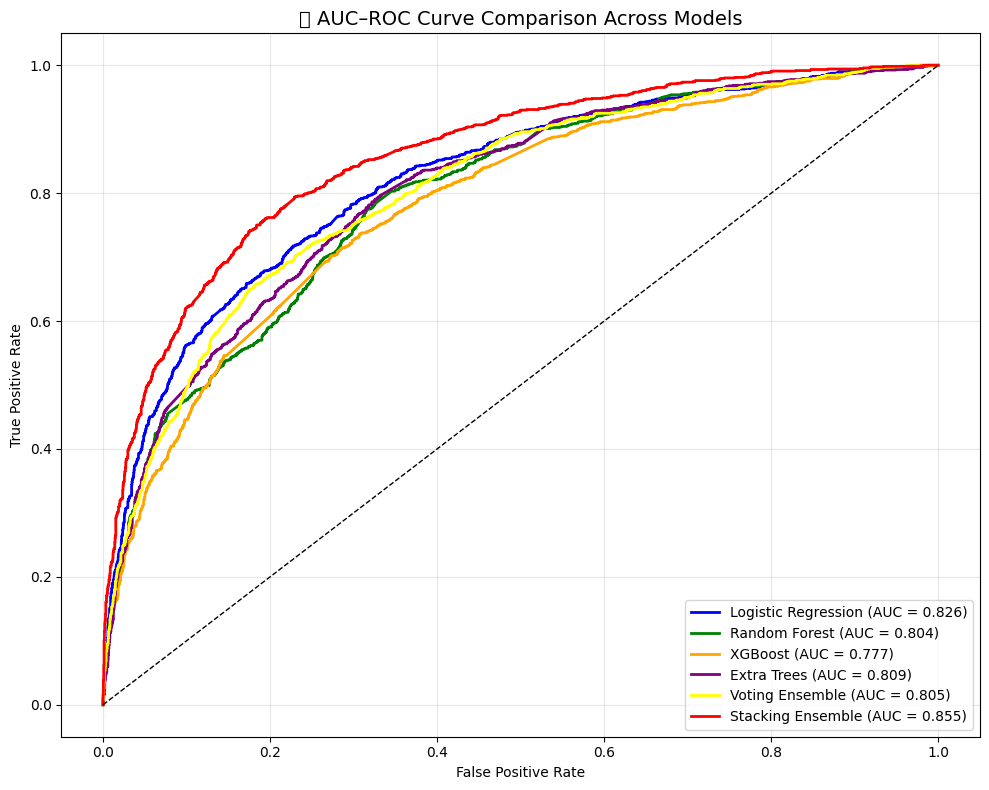

In [33]:
# ==========================================================
# 📈 AUC–ROC Curve Comparison for All Models
# ==========================================================

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# List of models to evaluate
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "XGBoost": xg,
    "Extra Trees": et,
    "Voting Ensemble": voting_clf,
    "Stacking Ensemble": stacking_clf
}

# Convert labels to binary format (needed for multiclass ROC)
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Initialize plot
plt.figure(figsize=(10, 8))
plt.title("🔹 AUC–ROC Curve Comparison Across Models", fontsize=14)
colors = ["blue", "green", "orange", "purple", "yellow","red"]

# Loop through models
for (name, model), color in zip(models.items(), colors):
    try:
        # Predict probabilities
        y_pred_proba = model.predict_proba(X_test)

        # Compute ROC for each class, then macro-average
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        auc_score = roc_auc_score(y_test_bin, y_pred_proba, average="macro", multi_class="ovr")

        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f"{name} (AUC = {auc_score:.3f})")

    except Exception as e:
        print(f"⚠️ Skipping {name}: {e}")

# Diagonal reference line
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Logistic Regression: 0.6483
Random Forest: 0.5914
XGBoost: 0.6079
Extra Trees: 0.6236


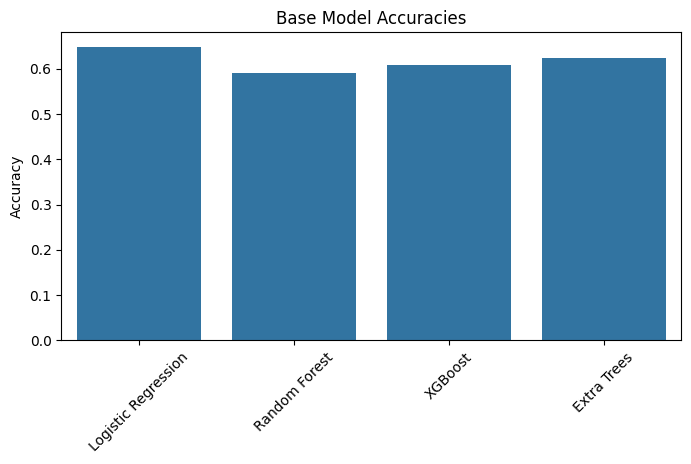

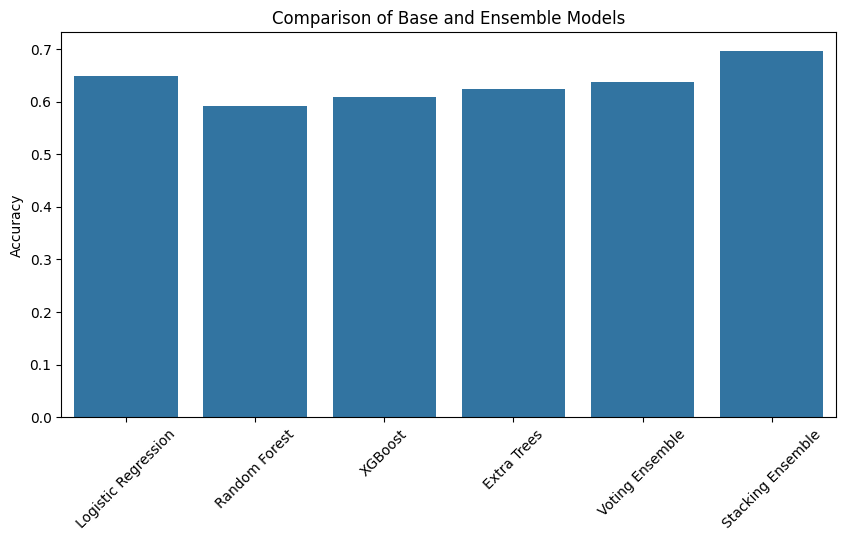


🏆 Best Performing Model: Stacking Ensemble with accuracy 0.70


In [14]:
models = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'XGBoost': xg,
    'Extra Trees': et
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

# Compare base model accuracies
plt.figure(figsize=(8,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Base Model Accuracies")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()
# Combine all results
results['Voting Ensemble'] = voting_acc
results['Stacking Ensemble'] = stacking_acc

# Plot comparison
plt.figure(figsize=(10,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Comparison of Base and Ensemble Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

# Print best model
best_model = max(results, key=results.get)
print(f"\n🏆 Best Performing Model: {best_model} with accuracy {results[best_model]:.2f}")



In [30]:
import joblib
import os

SAVE_DIR = "saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Save all models and preprocessors
joblib.dump(vectorizer, os.path.join(SAVE_DIR, "tfidf_vectorizer.pkl"))
joblib.dump(le, os.path.join(SAVE_DIR, "label_encoder.pkl"))

joblib.dump(lr, os.path.join(SAVE_DIR, "logistic_regression.pkl"))
joblib.dump(rf, os.path.join(SAVE_DIR, "random_forest.pkl"))
joblib.dump(xg, os.path.join(SAVE_DIR, "xgboost.pkl"))
joblib.dump(et, os.path.join(SAVE_DIR, "extra_trees.pkl"))
joblib.dump(voting_clf, os.path.join(SAVE_DIR, "voting_ensemble.pkl"))
joblib.dump(stacking_clf, os.path.join(SAVE_DIR, "stacking_ensemble.pkl"))

print("✅ All models and vectorizer saved successfully!")


✅ All models and vectorizer saved successfully!


✅ Starting Explainable AI analysis...


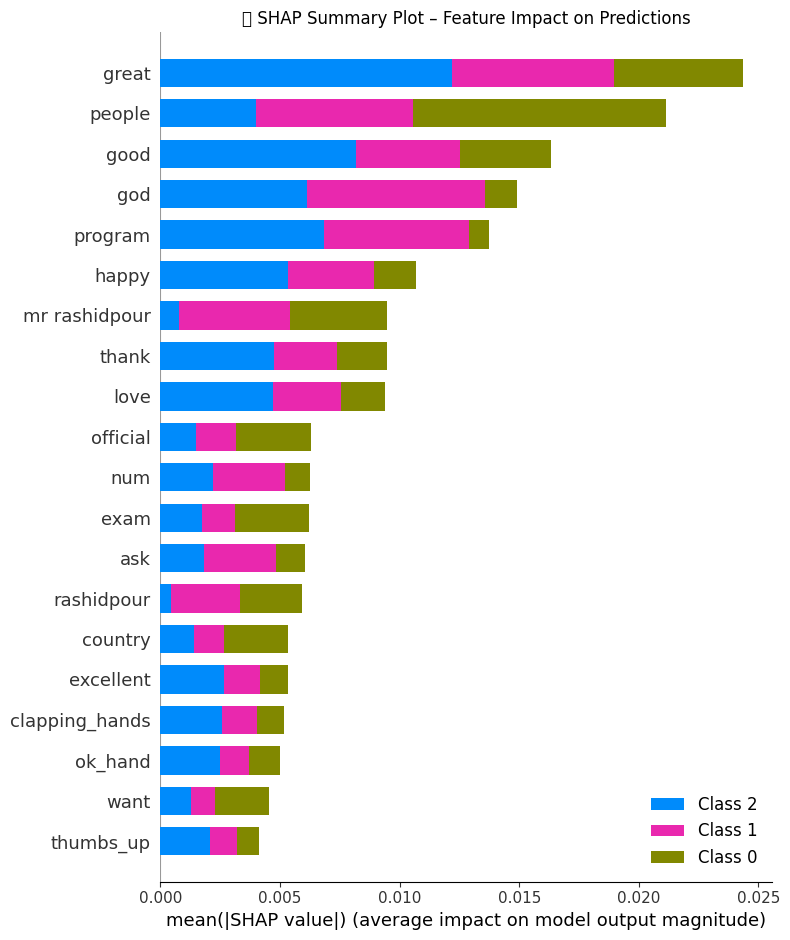

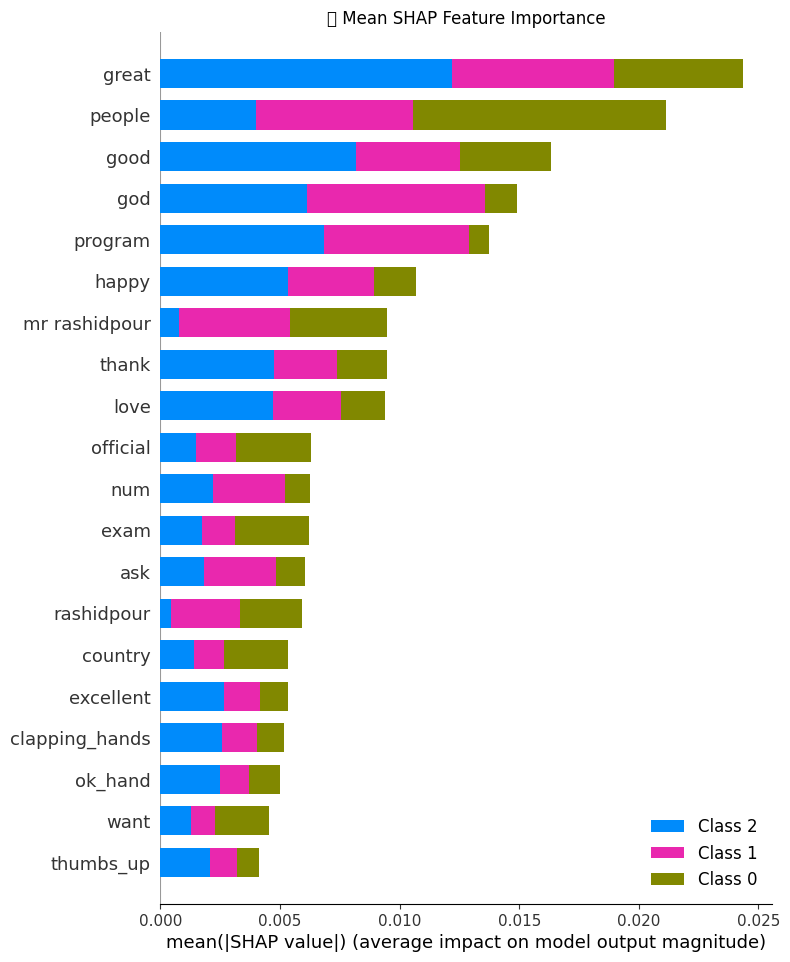

In [23]:
# ==========================================================
# 📘 Interpretable AI for Your Ensemble Models
# ==========================================================
import shap
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have:
# vectorizer, X_train_text, X_test_text, y_train, y_test
# and your final model: stacking_clf

print("✅ Starting Explainable AI analysis...")

# ==========================================================
# 1️⃣ Global Interpretability with SHAP
# ==========================================================
# Convert vectorized data to dense for tree-based models
X_sample = X_train[:500].toarray()   # use sample to speed up SHAP
feature_names = vectorizer.get_feature_names_out()

# Create SHAP explainer (TreeExplainer works for RF, ET, XGB)
explainer = shap.Explainer(stacking_clf.named_estimators_['rf'])
shap_values = explainer(X_sample)

# 🔹 Summary Plot (Global Feature Importance)
plt.title("🔍 SHAP Summary Plot – Feature Impact on Predictions")
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
plt.show()

# 🔹 Bar Plot (Mean Absolute SHAP Values)
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", show=False)
plt.title("🔹 Mean SHAP Feature Importance")
plt.show()





In [26]:
# ==========================================================
# 🧠 Interpretable AI (LIME) for custom input comment
# ==========================================================
import numpy as np
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline

# Combine vectorizer + your trained model (e.g., stacking_clf)
explainer_pipeline = make_pipeline(vectorizer, stacking_clf)  # use rf, xg, etc. if preferred

# Create a LIME text explainer
lime_explainer = lime.lime_text.LimeTextExplainer(class_names=[str(c) for c in le.classes_])

# ==========================================================
# 🔹 Function: explain a given comment
# ==========================================================
def explain_comment(comment_text):
    print(f"\n🗣️ Input Comment: {comment_text}")

    # Get model prediction probabilities
    probs = explainer_pipeline.predict_proba([comment_text])[0]
    pred_class = np.argmax(probs)
    pred_label = le.inverse_transform([pred_class])[0]

    print(f"🔹 Predicted Sentiment: {pred_label}")
    print("Prediction Probabilities:")
    for i, c in enumerate(le.classes_):
        print(f"  {c}: {probs[i]:.3f}")

    # Create LIME explanation
    explanation = lime_explainer.explain_instance(
        comment_text,
        explainer_pipeline.predict_proba,
        num_features=8
    )

# ==========================================================
# 🔍 Try out your own comments
# ==========================================================
examples = [
    "I really enjoyed watching this episode! Great content and fun host!",
    "I hate this episode, it was boring and pointless."
]

for comment in examples:
    explain_comment(comment)



🗣️ Input Comment: I really enjoyed watching this episode! Great content and fun host!
🔹 Predicted Sentiment: 1
Prediction Probabilities:
  -1: 0.192
  0: 0.088
  1: 0.720

🗣️ Input Comment: I hate this episode, it was boring and pointless.
🔹 Predicted Sentiment: -1
Prediction Probabilities:
  -1: 0.864
  0: 0.105
  1: 0.031


In [27]:
# ==========================================================
# 🚀 Deploy Sentiment Model on Hugging Face using Gradio
# ==========================================================
import gradio as gr
import numpy as np

def predict_sentiment(comment):
    # Predict probabilities
    probs = stacking_clf.predict_proba(vectorizer.transform([comment]))[0]
    pred_class = np.argmax(probs)
    pred_label = le.inverse_transform([pred_class])[0]

    # Prepare response
    result = {
        "Predicted Sentiment": str(pred_label),
        "Probabilities": {str(le.classes_[i]): float(probs[i]) for i in range(len(le.classes_))}
    }
    return result

# Define Gradio interface
demo = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=4, placeholder="Type a comment..."),
    outputs="json",
    title="🧠 Sentiment Analysis (Interpretable AI)",
    description="This model predicts sentiment (-1, 0, 1) for a given comment and returns class probabilities."
)

# Launch locally or on Hugging Face Spaces
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://77063f77407c9c93ce.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [16]:

!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e7d4623c897bc12f429b9fd4e30f1e79f8d391566ddd1c2973b719186f734dae
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
!pip install Emoji
!pip install demoji